In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import amp_pd_peptide

from scipy.optimize import minimize


In [2]:
def smape_plus_1(y_true, y_pred):
    y_true_plus_1 = y_true + 1
    y_pred_plus_1 = y_pred + 1
    metric = np.zeros(len(y_true_plus_1))
    
    numerator = np.abs(y_true_plus_1 - y_pred_plus_1)
    denominator = ((np.abs(y_true_plus_1) + np.abs(y_pred_plus_1)) / 2)
    
    mask_not_zeros = (y_true_plus_1 != 0) | (y_pred_plus_1 != 0)
    metric[mask_not_zeros] = numerator[mask_not_zeros] / denominator[mask_not_zeros]
    
    return 100 * np.nanmean(metric)

In [3]:
train_clinical_data = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv')
train_clinical_data['source'] = 'standard'

supplemental_clinical_data = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv')
supplemental_clinical_data['source'] = 'supplemental'

train_clinical_all = pd.concat([train_clinical_data, supplemental_clinical_data])

In [4]:
# delete visit_month 3, 5, 9 (there are no such visit_months in the Test API)
train_clinical_all = train_clinical_all[~train_clinical_all.visit_month.isin([3, 5, 9])]

In [5]:
train_clinical_all['pred_month'] = train_clinical_all['visit_month']

for plus_month in [6, 12, 24]:
    train_shift = train_clinical_all[['patient_id', 'visit_month', 'pred_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].copy()
    train_shift['visit_month'] -= plus_month
    train_shift.rename(columns={f'updrs_{i}': f'updrs_{i}_plus_{plus_month}' for i in range(1, 5)}, inplace=True)
    train_shift.rename(columns={'pred_month': f'pred_month_plus_{plus_month}'}, inplace=True)
    train_clinical_all = train_clinical_all.merge(train_shift, how='left', on=['patient_id', 'visit_month'])

train_clinical_all.rename(columns={f'updrs_{i}': f'updrs_{i}_plus_0' for i in range(1, 5)}, inplace=True)
train_clinical_all.rename(columns={'pred_month': f'pred_month_plus_0'}, inplace=True)
#train_clinical_all

In [6]:
def calculate_predictions(pred_month, trend, target):
    if target == 'updrs_4': pred_month = pred_month.clip(60, None)
    return np.round(trend[0] + pred_month * trend[1])

def function_to_minimize(x):    
    metric = smape_plus_1(
        y_true=y_true_array, 
        y_pred=calculate_predictions(
            pred_month=pred_month_array,
            trend=x,
            target=target
        )
    )
    return metric

target_to_trend = {}
for i in range(1, 5):
    target = f'updrs_{i}'
    columns_with_target = [f'{target}_plus_{plus_month}' for plus_month in [0, 6, 12, 24]]
    columns_with_pred_month = [f'pred_month_plus_{plus_month}' for plus_month in [0, 6, 12, 24]]
    y_true_array = train_clinical_all[columns_with_target].values.ravel()
    pred_month_array = train_clinical_all[columns_with_pred_month].values.ravel()
    trend = list(minimize(
        fun=function_to_minimize,
        x0=[0, 0.0048],
        method='Powell'
    ).x)
    target_to_trend[target] = trend
    
target_to_trend

{'updrs_1': [5.394793062665313, 0.027091086167821344],
 'updrs_2': [5.469498130092747, 0.02824188329658148],
 'updrs_3': [21.182145576879183, 0.08897763331790556],
 'updrs_4': [-4.645638591439615, 0.08511556737899556]}

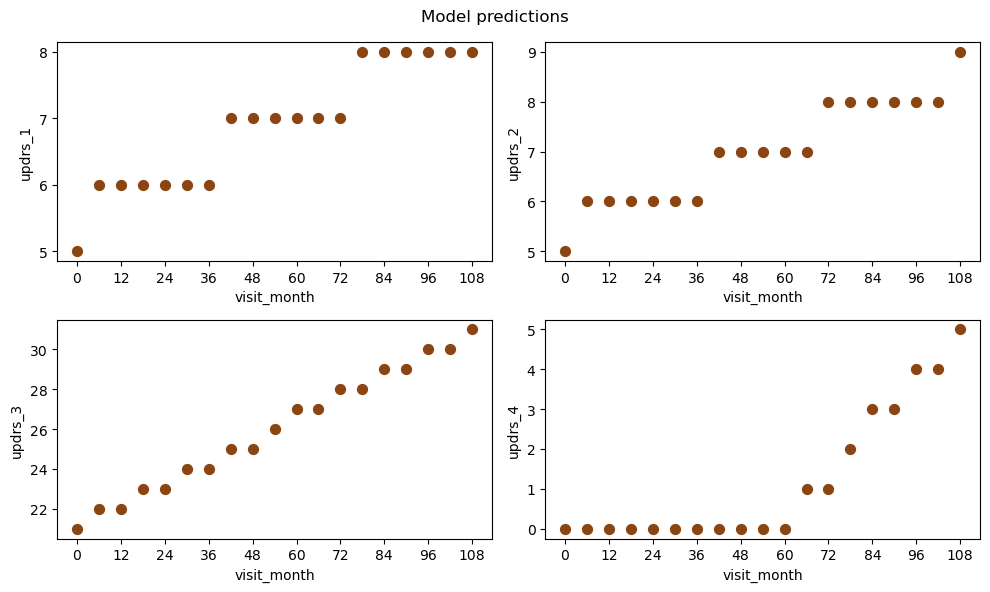

In [10]:
# Plot the predictions
plt.figure(figsize=(10, 6))
plt.suptitle('Model predictions')
dfff=pd.DataFrame()
for i in range(1, 5):
    target = f'updrs_{i}'
    if i ==1:
        dfff['updrs_1']=calculate_predictions(np.arange(0, 109, 6), target_to_trend[target], target)
    if i ==2:
        dfff['updrs_2']=calculate_predictions(np.arange(0, 109, 6), target_to_trend[target], target)
    if i ==3:
        dfff['updrs_3']=calculate_predictions(np.arange(0, 109, 6), target_to_trend[target], target)
    if i ==4:
        dfff['updrs_4']=calculate_predictions(np.arange(0, 109, 6), target_to_trend[target], target)
    plt.subplot(2, 2, i)
    
    plt.scatter(np.arange(0, 109, 6),
                calculate_predictions(np.arange(0, 109, 6), target_to_trend[target], target),
                color='saddlebrown', s=50)
    plt.xticks(np.linspace(0, 108, 10))
    plt.ylabel(f'updrs_{i}')
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('visit_month')
plt.tight_layout()
plt.show()

In [12]:
dfff

,updrs_1,updrs_2,updrs_3,updrs_4
0,5.0,5.0,21.0,0.0
1,6.0,6.0,22.0,0.0
2,6.0,6.0,22.0,0.0
3,6.0,6.0,23.0,0.0
4,6.0,6.0,23.0,0.0
5,6.0,6.0,24.0,0.0
6,6.0,6.0,24.0,0.0
7,7.0,7.0,25.0,0.0
8,7.0,7.0,25.0,0.0
9,7.0,7.0,26.0,0.0


In [13]:
def mergeall(test, test_proteins, test_peptides):
    # Merge the proteins data and peptides data on the common columns.
    test_proteins.fillna(0)
    test_peptides.fillna(0)
    merged_proteins_peptides = pd.merge(test_proteins, test_peptides, on = ['visit_id', 'visit_month', 'patient_id', 'UniProt'])

# Merge the merged protein-peptides data with the clinical data on the common columns.
    merged =  merged_proteins_peptides
    dfsub = pd.DataFrame(columns=parkinson_proteins+peptides_list)
    pivoted = merged.pivot(index = 'visit_id', columns = ['Peptide'], values = 'PeptideAbundance')
    merged2 = merged.groupby(by=['visit_id','UniProt']).mean().reset_index()
    pivoted2 = merged2.pivot(index = 'visit_id', columns = ['UniProt'], values = 'NPX').reset_index()
# Add visit_month, the 4 scores, and medication status.
    df = pd.merge(pivoted, pivoted2, on = 'visit_id', how = 'outer').set_index('visit_id')
    for col in parkinson_proteins+peptides_list:
        if col in df.columns:
            dfsub[col] = df[col]
        else:
            dfsub[col] = np.nan
    #dfsub=dfsub.fillna(df.mean())
    df4 = dfsub
    #df4=df4.fillna(method='bfill')
    df4=df4.fillna(df5mean)
    df4=df4.fillna(0)
    return df4

# Prediction

In [8]:
amp_pd_peptide.make_env.func_dict['__called__'] = False
env = amp_pd_peptide.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test files

# The API will deliver four dataframes in this specific order:
for test_clinical_data, test_peptides, test_proteins, sample_submission in iter_test:
    sample_submission['patient_id'] = sample_submission['prediction_id'].map(lambda x: int(x.split('_')[0]))
    sample_submission['visit_month'] = sample_submission['prediction_id'].map(lambda x: int(x.split('_')[1]))
    sample_submission['target_name'] = sample_submission['prediction_id'].map(lambda x: 'updrs_' + x.split('_')[3])
    sample_submission['plus_month'] = sample_submission['prediction_id'].map(lambda x: int(x.split('_')[5]))
    sample_submission['pred_month'] = sample_submission['visit_month'] + sample_submission['plus_month']
    
    for i in range(1, 5):
        target = f'updrs_{i}'
        mask_target = sample_submission['target_name'] == target
        sample_submission.loc[mask_target, 'rating'] = calculate_predictions(
            pred_month=sample_submission.loc[mask_target, 'pred_month'],
            trend=target_to_trend[target],
            target=target
        )
        
    # call env.predict for every iteration
    env.predict(sample_submission[['prediction_id', 'rating']])

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
